## Training VGG16 on CIFAR10 Dataset

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets 
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
from initialise import *

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Number of GPUs available: ',torch.cuda.device_count())
device

Number of GPUs available:  1


device(type='cuda', index=0)

In [4]:
torch.cuda.is_available() 

True

### Implement architecture of VGG network

In [5]:
#constructing a vgg block
class ConvBlock(nn.Module):
    
    def __init__(self, in_feature, out_feature, num_layers, pool = True):
        super(ConvBlock, self).__init__()
        channels = [in_feature] + [out_feature for i in range(num_layers)]
        layers = []
        for i in range(num_layers):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size= 3, padding= 1, bias = True))
            layers.append(nn.BatchNorm2d(channels[i+1], affine = True, track_running_stats= True))
            layers.append(nn.ReLU())
        if pool:
            layers.append(nn.MaxPool2d(kernel_size= 2, stride = 2, padding= 0))
            
        self.op = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.op(x)

In [6]:
class Vgg(nn.Module):
    
    def __init__(self, pretrained = False):
        super(Vgg, self).__init__()
        self.conv_block1 = ConvBlock(3, 64, 2)
        self.conv_block2 = ConvBlock(64, 128, 2)
        self.conv_block3 = ConvBlock(128, 256, 3)
        self.conv_block4 = ConvBlock(256, 512, 3)
        self.conv_block5 = ConvBlock(512, 512, 3)
        self.fc1 = nn.Linear(in_features= 512*7*7, out_features= 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        
        #initialise weights
        initialise_weights(self)
        
    def forward(self, x):
        #feed forward
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = F.adaptive_avg_pool2d(x, 7)
        
        B, C, H, W = x.shape  
        
        l = x.reshape(-1, C*H*W)   #reshape the out of conv layers as per first FC layer
        l = self.fc1(l)
        l = F.relu(l)
        l = F.dropout(l)
        l = self.fc2(l)
        l = F.relu(l)
        l = F.dropout(l)
        out = self.fc3(l)
        
        return F.softmax(out,1)
    

### Load the dataset and visualise few images

In [7]:
class Data():
    
    def __init__(self):
        
        self.train_set = datasets.CIFAR10(
        root = './data',
        train = True,
        download = True,
        transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
        )

        self.test_set = datasets.CIFAR10(
        root= './data',
        train= False,
        download = True,
        transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
        )
        
    def get_data(self):
        return [self.train_set, self.test_set]

In [8]:
data = Data()
train, test = data.get_data()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(train, batch_size= 64, shuffle= True)
test_loader = torch.utils.data.DataLoader(test, batch_size= 10000, shuffle= True)

In [10]:
images, labels = next(iter(train_loader))

In [11]:
images[0][0].shape

torch.Size([224, 224])

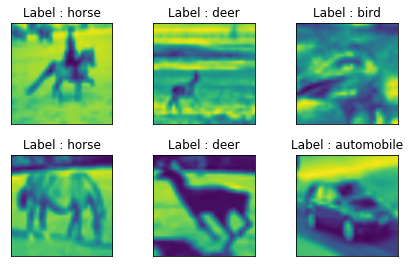

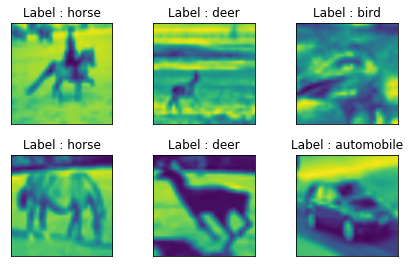

In [12]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], interpolation='bicubic')
  plt.title("Label : {}".format(train.classes[labels[i]]))
  plt.xticks([])
  plt.yticks([])
fig

### Initialise the model, pretrained or from scratch 

In [13]:
def initialise_model(pretrained = True):
    
    model = None
    if pretrained:
        model = models.vgg16_bn(pretrained= True)
        in_feat = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_features= in_feat, out_features= 10)
        model.to(device)
        
        count = 0
        for name, params in model.named_parameters():
            count += 1

            if count < 55:
                params.requires_grad = False
    else:
        model = Vgg()
        model.to(device)

    return model

In [14]:
net = initialise_model()

### Training 

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

def train(epoch, losses, net):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        losses.append(loss.item())
        _, predicted = outputs.max(1)  #this returns values and labels
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [16]:
def test(test_loader,test_losses, net):
    
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
            test_losses.append(loss.item())
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print('Loss: %.3f | Acc: %.3f%%'
                  % (test_loss, 100.*correct/len(test_loader.dataset)))

In [21]:


losses = []
test_losses = []

epochs = 3


for epoch in range(1,epochs+1):
    train(epoch, losses, net)
    #test(test_loader, test_losses, net)     # did not call because it was not fitting in gpu memory with batch size 1000


Epoch: 1
0 782 Loss: 0.917 | Acc: 68.750% (44/64)
100 782 Loss: 0.739 | Acc: 74.319% (4804/6464)
200 782 Loss: 0.737 | Acc: 74.471% (9580/12864)
300 782 Loss: 0.735 | Acc: 74.336% (14320/19264)
400 782 Loss: 0.733 | Acc: 74.377% (19088/25664)
500 782 Loss: 0.726 | Acc: 74.757% (23970/32064)
600 782 Loss: 0.724 | Acc: 74.774% (28761/38464)
700 782 Loss: 0.720 | Acc: 74.913% (33609/44864)

Epoch: 2
0 782 Loss: 0.563 | Acc: 82.812% (53/64)
100 782 Loss: 0.673 | Acc: 76.795% (4964/6464)
200 782 Loss: 0.687 | Acc: 76.026% (9780/12864)
300 782 Loss: 0.689 | Acc: 75.862% (14614/19264)
400 782 Loss: 0.691 | Acc: 75.686% (19424/25664)
500 782 Loss: 0.685 | Acc: 75.948% (24352/32064)
600 782 Loss: 0.684 | Acc: 75.920% (29202/38464)
700 782 Loss: 0.684 | Acc: 75.958% (34078/44864)

Epoch: 3
0 782 Loss: 0.561 | Acc: 81.250% (52/64)
100 782 Loss: 0.681 | Acc: 76.145% (4922/6464)
200 782 Loss: 0.674 | Acc: 76.329% (9819/12864)
300 782 Loss: 0.670 | Acc: 76.557% (14748/19264)
400 782 Loss: 0.663 | A

Text(0.5, 0, 'Epochs')

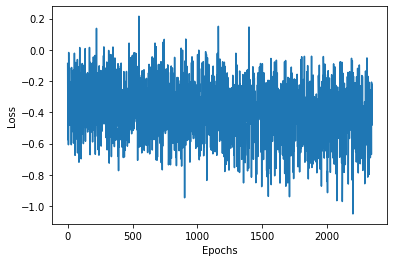

In [22]:
log_loss = [np.log(x) for x in losses]
plt.plot(log_loss)

plt.ylabel('Loss')
plt.xlabel('Epochs')

### Saving and loading the model

In [24]:

# save the model 
checkpoint = {'input_size': 224,
              'output_size': 10,
              'epoch': epoch +1,
              'optimizer': optimizer.state_dict(),
              'state_dict': net.state_dict()}

torch.save(checkpoint, 'checkpoints/checkpoint.pth')

In [27]:
# load the model

def load_checkpoint(filepath):
    state_dict = torch.load(filepath)
    epoch = state_dict['epoch']
    optimizer = state_dict['optimizer']
    net.load_state_dict(state_dict['state_dict'])
    
    return net

In [28]:
net = load_checkpoint('checkpoints/checkpoint.pth')
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)